# AUTOMATE DATA CLEANING

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy import stats
import random

import re
from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype
from datetime import datetime
from typing import Union, Optional
import phonenumbers

### 1. Basic Data Quality Checks

Using **df.info()** provides:  
- data type (dataFrame)
- number of rows
- number of columns
- number of values not null in columns
- columns type


In [119]:
df = pd.read_csv('hr_data_1.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18 non-null     int64  
 1   name             17 non-null     object 
 2   age              17 non-null     float64
 3   gender           18 non-null     object 
 4   email            18 non-null     object 
 5   income           17 non-null     float64
 6   job_title        18 non-null     object 
 7   department       18 non-null     object 
 8   start_date       18 non-null     object 
 9   education        18 non-null     object 
 10  customer_rating  16 non-null     float64
 11  comments         17 non-null     object 
 12  phone_number     18 non-null     object 
 13  country          18 non-null     object 
 14  purchase_amount  18 non-null     object 
dtypes: float64(3), int64(1), object(11)
memory usage: 2.2+ KB


Check for:
- Duplicated rows
- number of unique values in columns
- columns with missing values and percentage of missingness

In [120]:
def data_characteristics(data: Union[pd.DataFrame, pd.Series]) -> None:
    """
    Analyzes and prints key characteristics of a pandas DataFrame or Series.

    This function calculates and displays the following information:
    - The total number of duplicate rows/values.
    - The memory usage of the DataFrame/Series in megabytes (MB).
    - The number of unique values for each column (if a DataFrame) or for the Series itself.

    Args:
        data (pd.DataFrame | pd.Series): The pandas DataFrame or Series to analyze.

    Returns:
        None: This function does not return any value; it prints the characteristics
              directly to the console.

    Raises:
        TypeError: If the input `data` is not a pandas DataFrame or Series.
    """
    if not isinstance(data, (pd.DataFrame, pd.Series)):
        raise TypeError("Input 'data' must be a pandas DataFrame or Series.")

    print("\n--- Data Characteristics ---")

    # Calculate and print the number of duplicate rows/values
    print(f"\nDuplicates: {data.duplicated().sum()}")

    # Return memory usage in MB
    memory_mb = data.memory_usage(deep=True).sum() / (1024**2)
    print(f"\nMemory Usage: {memory_mb:.4f} MB") # Formatted to 4 decimal places

    # Return number of unique values
    print(f"\nUnique Values:\n {data.nunique()}")

In [121]:
data_characteristics(df)


--- Data Characteristics ---

Duplicates: 3

Memory Usage: 0.0135 MB

Unique Values:
 id                 15
name               13
age                14
gender              6
email              15
income             14
job_title          14
department          9
start_date         14
education          12
customer_rating    12
comments           14
phone_number       14
country             8
purchase_amount    15
dtype: int64


In [124]:
def null_check(data: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies columns containing any null values (NaN or None) in a dataframe,
    calculates the total count of missing values, and their percentage
    of missingness.

    Args:
        data (pd.DataFrame): The input DataFrame to check for missing values.

    Returns:
        pd.DataFrame: A DataFrame with three columns:
                      - 'column': The name of the column with missing values.
                      - 'missing_count': The total number of missing values in that column.
                      - 'missing_percentage': The percentage of missing values (0.0 to 1.0).
                      Returns an empty DataFrame if no missing values are found or
                      if the input DataFrame is empty.
    """
    data = data.copy()
    
    # Check if Dataframe is empty
    if data.empty:
        print("Empty DataFrame. No missing values to check!")
    
    # Get count of missing values for each column in dataframe
    missing_counts = data.isnull().sum()
    missing_counts = missing_counts[missing_counts.values > 0]
    # Get percentage of missing values
    missing_percentages = round((missing_counts / len(data)), 2)

    # Make dataframe for columns with missing values
    missing_summary = pd.DataFrame({'column': missing_counts.index,
                                    'missing_count': missing_counts.values,
                                    'missing_percentage': missing_percentages.values})
    
    # Print summary
    if missing_summary.empty:
        print("No column has missing value(s) in this dataframe")
    
    return missing_summary
        

In [125]:
null_check(df)

,column,missing_count,missing_percentage
0,name,1,0.06
1,age,1,0.06
2,income,1,0.06
3,customer_rating,2,0.11
4,comments,1,0.06


### 2. General Data Cleaning

Perform the following:
- remove duplicates from data
- drop completely empty rows from data
- drop columns with more than 40% missing data points

In [126]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """"
    Clean a dataset by removing duplicated or empty rows if available,
    dropping columns with high percentage of misssing data points.

    Args:
        data (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The cleaned dataFrame.
    """

    print("--- Initiating data cleaning process ---")
    clean_data = data.copy()

    # Drop duplicated rows if available
    if any(clean_data.duplicated()):
        initial_rows = len(clean_data)
        clean_data = clean_data.drop_duplicates()
        rows_after_drop = len(clean_data)
        print(f"\n\nDropped {initial_rows - rows_after_drop} duplicated row(s).\n")
    else:
        print("\n\nNo duplicated rows found.\n")

    # Drop completely empty rows
    empty_rows_count = clean_data.isnull().all(axis=1).sum()

    if empty_rows_count > 0:
        clean_data = clean_data.dropna(how='all')
        print(f"Dropped {empty_rows_count} completely empty row(s).\n")
    else:
        print("No completely empty rows found.\n")
    
    # Drop columns with > 40% of data points missing
    pct_missing = clean_data.isnull().sum() / len(clean_data)
    columns_to_drop = pct_missing[pct_missing > .4].index.tolist()
    
    if columns_to_drop:
        clean_data = clean_data.drop(columns_to_drop, axis=1)
        dropped_columns_info = ", ".join([
            f"{col} ({round(pct_missing[col]*100, 2)}%)"
            for col in columns_to_drop
        ])
        print(f"Dropped columns with more than 40% missing values: {dropped_columns_info}%\n\n")
    else:
        print("No columns found with more than 40% missing values.\n\n")    

    print("--- Data cleaning process complete ---")
    return clean_data

In [127]:
df_clean = clean_data(df)

--- Initiating data cleaning process ---


Dropped 3 duplicated row(s).

No completely empty rows found.

No columns found with more than 40% missing values.


--- Data cleaning process complete ---


In [128]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15 non-null     int64  
 1   name             14 non-null     object 
 2   age              14 non-null     float64
 3   gender           15 non-null     object 
 4   email            15 non-null     object 
 5   income           14 non-null     float64
 6   job_title        15 non-null     object 
 7   department       15 non-null     object 
 8   start_date       15 non-null     object 
 9   education        15 non-null     object 
 10  customer_rating  13 non-null     float64
 11  comments         14 non-null     object 
 12  phone_number     15 non-null     object 
 13  country          15 non-null     object 
 14  purchase_amount  15 non-null     object 
dtypes: float64(3), int64(1), object(11)
memory usage: 1.9+ KB


### 2. Standardize Data Types

- convert string dates to datetime

In [138]:
def standardize_datetime(data: pd.DataFrame) -> tuple[pd.DataFrame, list[str]]:
    """
    Iterates through DataFrame columns, identifies potential date columns
    based on keywords in their names, and attempts to convert them to datetime objects.
    It handles mixed date formats and invalid entries.

    Args:
        data (pd.DataFrame): The input DataFrame.

    Returns:
        - pd.DataFrame: The DataFrame with identified date columns converted to datetime type.  
        
        - list: List of columns successfully converted to datetime.
    """
    print("--- Initiating datetime standardization process ---")
    # Make copy of data
    data = data.copy()

    # Collect successfully convertd column(s)
    columns_converted: list[str] = []
    
    for column in data.columns:
            # Check if column  is string and its name contains an identifying keyword
            if "date" in column.lower() and data[column].dtype == 'object':
                print(f"Attempting to convert '{column}' column from {data[column].dtype} to datetime type...\n")
                try:
                    # Perform conversion
                    datetime_series = pd.to_datetime(data[column], format='mixed', errors='coerce')

                    if is_datetime64_any_dtype(datetime_series) and not datetime_series.isnull().all():
                        data[column] = datetime_series
                        print(f"'{column}' column is now of {data[column].dtype} type\n")
                    
                        # Report how much, if any values where coerced to NaT
                        coerced = datetime_series.isnull().sum()
                        if coerced > 0:
                            print(f"{coerced} invalid dates where coerced to NaT in '{column}' column\n")
                        
                        columns_converted.append(column)
                        
                        # Inform on whether any column(s) were converted
                        if len(columns_converted) == 0:
                            print("No columns matching identifying keyword(s) were found in the DataFrame to convert.")
                        else:
                            print(f"Datetime conversion complete for the following column(s):")
                            print(columns_converted)
                except Exception as e:
                     # Report if the dataframe itself has issue(s)
                     print(f"Error {e} occured while converting {column} column to date type")
    
    print("\n--- Datetime standardization process complete ---")
    return data
                        

In [139]:
# type before standardizing
df['start_date'].dtype

dtype('O')

In [140]:
# execute
df_clean = standardize_datetime(df)

--- Initiating datetime standardization process ---
Attempting to convert 'start_date' column from object to datetime type...

'start_date' column is now of datetime64[ns] type

Datetime conversion complete for the following column(s):
['start_date']

--- Datetime standardization process complete ---


In [141]:
df_clean['start_date'].dtype

dtype('<M8[ns]')

In [ ]:
# type after standardizing
df['start_date']

0    2019-03-15
1    2020-01-10
2    2018-05-20
3    2017-11-05
4    2021-02-28
5    2019-08-12
6    2020-07-15
7    2020-01-10
8    2022-04-18
9    2021-01-15
10   2015-09-30
11   2018-12-05
12   2022-02-10
13   2017-06-22
14   2019-11-18
15   2022-04-18
16   2018-12-05
17   2020-07-15
Name: start_date, dtype: datetime64[ns]

- convert numeric strings to actual numbers

In [145]:
def string_to_numeric(data: pd.DataFrame,
                      exclude_keywords: list[str]=["phone", "date"],
                      ) -> pd.DataFrame:
    """
    Iterates through DataFrame columns, attempts to convert string-like
    numeric values to actual numeric types, while skipping specified
    keyword-containing columns and handling non-numeric strings.

    Args:
        data (pd.DataFrame): The input DataFrame.
        exclude_keywords (list): List of  keywords to detect in column names. These columns can be numeric, but do not have numeric value.

    Returns:
        pd.DataFrame: The DataFrame with applicable columns converted to numeric.
    """
    print("--- Initiating string to numeric conversion process ---\n")
    data = data.copy()
    remove_symbols = ["$", "€", "£", "¥", ",", "%"]

    for column in data.columns:
        # Check if column does not contain exclude keywords
        if any(keyword not in column.lower() for keyword in exclude_keywords):
            if data[column].dtype == 'object':
                try:
                    column_to_numeric = (
                        data[column].str.strip()
                                    .str.replace(r"^\((.*)\)$", r"-\1", regex=True) # handle negative values in parentheses
                    )
                    # Drop remove symbols from column
                    for symbol in remove_symbols:
                        column_to_numeric = column_to_numeric.str.replace(symbol, '')
                    
                    # Empty strings or whitespaces to NaN
                    column_to_numeric = column_to_numeric.replace(r"^\s*$", np.nan, regex=True)
                    # Convert to numeric
                    column_to_numeric = pd.to_numeric(column_to_numeric, errors='coerce')

                    # Check if significant proportion of data has been converted to numeric
                    original_not_nan_count = data[column].dropna().shape[0]
                    converted_not_nan_count = column_to_numeric.dropna().shape[0]

                    if (original_not_nan_count > 0 and 
                        (converted_not_nan_count / original_not_nan_count) > .5):
                        # Add cleaned column to dataframe
                        data[column] = column_to_numeric
                        print(f"\n'{column}' column successfully converted to numeric")

                except Exception as e:
                    print(f"{e} has occured while converting {column} to numeric!")
            else:
                try:
                    # Ensure consistency of all numeric columns
                    converted_numeric = pd.to_numeric(data[column], errors='coerce')

                    # only update if conversion actually changed dtype or introduced NaNs
                    if not is_numeric_dtype(data[column].dtype) or (is_numeric_dtype(data[column].dtype) and not converted_numeric.equals(data[column])):
                        data[column] = converted_numeric
                        print(f"{column} column converted to consistent numeric type successfully.")
                    else:
                        print(f"'{column}' column is already of type {data[column].dtype}; no change needed.")
                
                except Exception as e:
                    print(f"An error occurred while attempting to standardize '{column}' (type {data[column].dtype}): {e}")

    print("\n--- String to numeric conversion process complete ---")
    return data


In [143]:
df['purchase_amount'].dtype

dtype('O')

In [146]:
df_clean = string_to_numeric(df)

--- Initiating string to numeric conversion process ---

'id' column is already of type int64; no change needed.
'age' column is already of type float64; no change needed.
'income' column is already of type float64; no change needed.
'customer_rating' column is already of type float64; no change needed.

'purchase_amount' column successfully converted to numeric

--- String to numeric conversion process complete ---


In [147]:
df_clean['purchase_amount'].dtype

dtype('float64')

### 4. Handle Text Data

- Standardize Phone Numbers (Based on Region)

In [148]:
# Helper function to assist standardize_phone function
def _parse_and_format_phone(phone_str: str,
                            region: str,
                            output_format: phonenumbers.PhoneNumberFormat,
                            strictly_validate: bool
                            ) -> Union[str, pd.NA]:
    """
    Helper function to parse, validate, and format a  phone number string.

    Args:
        phone_str (str): The phone number string to process.
        region (str): Two-letter ISO 3166-1 country code to assume for phone numbers without a country code e.g.("US", "UK").
        output_format (phonenumbers.PhoneNumberFormat): Preferred output format for phone number.
        strictly_validate (boolean): If True, performs strict validation on phone before formatting,
                                     to ensure the phone actually is valid for the specified region.
                                     If False, only checks whether phone is struturally possible before formatting.

    Returns:
        str | pd.NA: The formatted phone number string if valid, otherwise pd.NA.
    """
    # Take care of NaN, non-strings or empty strings
    if pd.isna(phone_str) or not isinstance(phone_str, str) or not phone_str.strip():
        print(f"'{phone_str}' is NA/empty/non-string. Returning NA.")
        return pd.NA
    
    try:
        # Return phone as specified output if phone is actually correct and is valid for its region
        parsed_phone = phonenumbers.parse(phone_str, region)
        is_possible = phonenumbers.is_possible_number(parsed_phone)
        is_valid = phonenumbers.is_valid_number(parsed_phone)
        
        # Perform validation check before formatting phone
        if strictly_validate:
            if is_possible and is_valid:
                return phonenumbers.format_number(parsed_phone, output_format)
            else:
                # Return pd.na if phone is not valid
                return pd.NA
        else:
            if is_possible:
                return phonenumbers.format_number(parsed_phone, output_format)
            else:
                # Return pd.na if phone is not structurally possible
                return pd.NA
            
    except phonenumbers.NumberParseException as e:
        # Catch unexpected Errors during processing (e.g.. empty string, malformed phone)
        return pd.NA
    except Exception as e:
        print(f"Unexpected error processing '{phone_str}': {e}")
        return pd.NA


In [149]:
# Main function for phone standardization
def standardize_phone(data: pd.DataFrame,
                      region: str = "US",
                      output_format: phonenumbers.PhoneNumberFormat = phonenumbers.PhoneNumberFormat.E164,
                      strictly_validate: bool = False,
                      keywords: list[str] = None
                      ) -> pd.DataFrame:
    """
    Main function to standardize phone number columns across an entire DataFrame. 
    
    It automatically identifies columns likely containing phone data
    based on common naming conventions (keywords), then processes each identified
    column to parse, validate, and format phone numbers to a consistent standard.
    It leverages the `phonenumbers` library for robust handling of international
    formats, invalid entries, and missing values.

    Args:
        data (pd.DataFrame): The input DataFrame that needs phone number standardization.
        keywords (list[str], optional): A list of substrings to look for in column names.
                                        Columns whose names (case-insensitively) contain
                                        any of these keywords will be considered for
                                        phone number standardization.
                                        Defaults to common phone-related terms.
        region (str, optional): The two-letter ISO 3166-1 country code
                                        (e.g., "US", "GH", "GB") to assume for
                                        phone numbers that do not have an explicit
                                        country code (e.g., "5551234567"). This is
                                        critical for correct parsing. Defaults to "US".
        output_format (phonenumbers.PhoneNumberFormat, optional): The desired
                                                                  standard output format
                                                                  for the phone numbers.
                                                                  Defaults to E.164.
                                                                  Options include:
                                                                  - `phonenumbers.PhoneNumberFormat.E164` (e.g., "+15551234567")
                                                                  - `phonenumbers.PhoneNumberFormat.INTERNATIONAL` (e.g., "+1 555-123-4567")
                                                                  - `phonenumbers.PhoneNumberFormat.NATIONAL` (e.g., "(555) 123-4567" for US)

    Returns:
        pd.DataFrame: A new DataFrame with the identified phone number column(s)
                      standardized. Original columns are unchanged if no phone
                      data is found or processed.
    """
    print("--- Initiating phone number standardization process ---\n")

    data = data.copy()

    # Defined default keywords for phone column detection if None
    if keywords == None:
        keywords = ["phone", "number", "contact", "mobile", "tel", "cell", "telephone", "fax"]

    processed_columns: list[str] = []

    # Retreive potential phone number columns
    for column in data.columns:

        if any(keyword in column.lower() for keyword in keywords):
            print(f"Processing potential phone column '{column}'\n")

            # Prepare, parse, format and validate phone using the helper function
            process_phone = (
                data[column].astype(str)
                            .replace(r"^\s*$", "", regex=True)
                            .replace("nan", "", regex=True)
            )

            # Perform validation check before formatting phone
            if strictly_validate:
                data[column] = process_phone.apply(
                    lambda x: _parse_and_format_phone(x, region, output_format, strictly_validate=True)
                )
                data[column] = data[column].astype(pd.StringDtype())
                print(f"'{column}' column processed.")
            else:
                # Ignore validation check, format phone
                data[column] = process_phone.apply(
                    lambda x: _parse_and_format_phone(x, region, output_format, strictly_validate=False)
                )
                data[column] = data[column].astype(pd.StringDtype())
                print(f"'{column}' column processed.")

            # Report on na or invalid phone numbers
            number_of_na = data[column].isnull().sum()
            if number_of_na > 0:
                print(f"{number_of_na} phone numbers failed to parse/validate. Set to NA in '{column}' column.\n")

            processed_columns.append(column)
        
    # Report on whether any column(s) were standardized
    if len(processed_columns) == 0:
        print("No columns matching phone keywords were found in the DataFrame to standardize.")
    else:
        print(f"Phone number standardization complete for the following column(s):")
        print(processed_columns)
    
    print("\n--- Phone number standardization process complete ---")
    return data

In [ ]:
# type before standardizing
df['phone_number'].dtype

dtype('O')

In [ ]:
df_clean = standardize_phone(df, region="US")

--- Initiating phone number standardization process ---

Processing potential phone column 'phone_number'

'phone_number' column processed.
Phone number standardization complete for the following column(s):
['phone_number']

--- Phone number standardization process complete ---


In [ ]:
# type after standardizing
df_clean['phone_number']

0     +15551234567
1     +15559876543
2     +15551234567
3     +15555555555
4     +15557890123
5     +15551112222
6     +15559876543
7     +15559876543
8     +15551237890
9     +15554443333
10    +15552221111
11    +15557894561
12    +15551112222
13    +15553339876
14    +15556667777
15    +15551237890
16    +15557894561
17    +15559876543
Name: phone_number, dtype: string

- clean and validate email

In [3]:
# Helper function for email validation and cleaning
def _clean_email(email: Union[str, float]) -> Union[str, float]:
    """
    Cleans and validates a single email string.

    This helper function performs the following steps:
    1. Handles pandas NaN values, returning them directly.
    2. Converts the input to a string and strips leading/trailing whitespace.
    3. Validates the email against a common regular expression pattern.
       The pattern allows alphanumeric characters, '.', '_', '%', '+', '-' before '@',
       and alphanumeric characters, '.', '-' after '@', followed by a top-level domain
       of at least two letters.
    4. If the email is valid, it's converted to lowercase and returned.
    5. If the email is not a string, or does not match the valid pattern,
       it returns `np.nan` (Not a Number) to indicate an invalid or unfixable email.

    Args:
        email (Union[str, float]): The email string to clean. Can also be a float
                                   if it's a NaN value from a DataFrame.

    Returns:
        Union[str, float]: The cleaned, lowercase email string if valid,
                           otherwise `np.nan`.

    Example:
        >>> clean_email(" test@example.com ")
        'test@example.com'
        >>> clean_email("invalid-email")
        nan
        >>> clean_email("user@domain.co.uk")
        'user@domain.co.uk'
        >>> clean_email(np.nan)
        nan
        >>> clean_email(123)
        nan
    """
    # Handle NaN values
    if pd.isna(email):
        return np.nan

    # Ensure input is string
    if not isinstance(email, str):
        return np.nan
    
    # Strip leading/trailing whitespace.
    email = email.strip()
    
    # Basic valid email pattern
    email_pattern = r"^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9._]+\.[a-zA-Z]{2,}$"


    # Check if email is valid then return, else return null
    if re.match(email_pattern, email):
        return email.lower()
    else:
        return np.nan

In [10]:
# Main function
def clean_email(
    data: pd.DataFrame,
    email_keywords: list[str] = None
) -> pd.DataFrame:
    """
    Identifies and cleans email columns within a pandas DataFrame.

    This function iterates through the DataFrame's columns, identifies potential
    email columns based on a list of keywords, and applies the `clean_email`
    helper function to clean and validate the email entries in those columns.

    Args:
        df (pd.DataFrame): The input pandas DataFrame.
        email_keywords (List[str], optional): A list of keywords (case-insensitive)
            to identify columns likely containing email addresses. Common keywords
            include 'email', 'mail', 'e-mail', 'contact_email', etc.
            If None, a default list ['email', 'mail', 'e-mail', 'contact'] will be used.

    Returns:
        pd.DataFrame: A new DataFrame with the identified email columns cleaned.
                      Original DataFrame is not modified.

    Raises:
        TypeError: If the input `df` is not a pandas DataFrame.

    Example:
        >>> data = {
        ...     'id': [1, 2, 3, 4],
        ...     'customer_email': [' test@example.com ', 'invalid', 'user@domain.co.uk', np.nan],
        ...     'mailing_address': ['123 Main St', '456 Oak Ave', '789 Pine Ln', '101 Elm St'],
        ...     'email_backup': ['another@example.org', 'no_at_sign', 'user@domain', 'valid@sub.domain.com']
        ... }
        >>> df = pd.DataFrame(data)
        >>> cleaned_df = clean_email_columns(df)
        Processing column: customer_email
        Processing column: email_backup
        >>> print(cleaned_df[['customer_email', 'email_backup']])
             customer_email        email_backup
        0  test@example.com another@example.org
        1               NaN                 NaN
        2  user@domain.co.uk                 NaN
        3               NaN  valid@sub.domain.com
    """
    print("--- Initiating email cleaning process ---\n\n")
    
    data = data.copy()

    # Define default email_keywords
    if email_keywords == None:
        email_keywords = ['email', 'mail', 'e-mail', 'contact']
    
    cleaned_email_columns: list[str] = []

    # Try to identify potential email columns using email_keywords
    for column in data.columns:
        if any(keyword in column.lower() for keyword in email_keywords):
            print(f"Processing column: '{column}'...\n")
            cleaned_email_columns.append(column)
            try:
                # Apply helper function to identified columns
                data[column] = data[column].apply(
                    lambda x: _clean_email(x)
                )
            except Exception as e:
                print(f"Error cleaning column '{column}': {e}.\n")
    
    if not cleaned_email_columns:
        print(f"No columns indentied as email columns based on provided keywords.\n")
    else:
        print(f"Successfully cleaned email columns:")
        print(cleaned_email_columns)
    
    print("\n\n--- Email cleaning process complete ---")

    return data

In [154]:
df = pd.read_csv("hr_data_1.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18 non-null     int64  
 1   name             17 non-null     object 
 2   age              17 non-null     float64
 3   gender           18 non-null     object 
 4   email            18 non-null     object 
 5   income           17 non-null     float64
 6   job_title        18 non-null     object 
 7   department       18 non-null     object 
 8   start_date       18 non-null     object 
 9   education        18 non-null     object 
 10  customer_rating  16 non-null     float64
 11  comments         17 non-null     object 
 12  phone_number     18 non-null     object 
 13  country          18 non-null     object 
 14  purchase_amount  18 non-null     object 
dtypes: float64(3), int64(1), object(11)
memory usage: 2.2+ KB


In [155]:
# type before standardizing
df['email']

0         john.smith@email.com
1           jane.doe@email.com
2                  bob.j@email
3        mike.wilson@email.com
4            sarah.w@email.com
5               alex@email.com
6              emilyincomplete
7     different.jane@email.com
8       chris.martin@email.com
9             lisa.j@email.com
10           david.t@email.com
11              jennifer@email
12            mscott@email.com
13       amanda.king@email.com
14         ryan.chen@email.com
15      chris.martin@email.com
16              jennifer@email
17            emily@incomplete
Name: email, dtype: object

In [13]:
df = clean_email(df)

--- Initiating email cleaning process ---


Processing column: 'email'...

Successfully cleaned email columns:
['email']


--- Email cleaning process complete ---


In [ ]:
# type after standardizing
df['email']

0         john.smith@email.com
1           jane.doe@email.com
2                          NaN
3        mike.wilson@email.com
4            sarah.w@email.com
5               alex@email.com
6                          NaN
7     different.jane@email.com
8       chris.martin@email.com
9             lisa.j@email.com
10           david.t@email.com
11                         NaN
12            mscott@email.com
13       amanda.king@email.com
14         ryan.chen@email.com
15      chris.martin@email.com
16                         NaN
17                         NaN
Name: email, dtype: object

- handle basic text inconsistencies

In [ ]:
df['name'] = df['name'].str.title()     #convert names title case
df['country'] = df['country'].str.upper()   #convert country names to uppercase
df['job_title'] = df['job_title'].str.lower()   #convert country names to lowercase

- standardize text data type

In [87]:
# Function for mapping text inconsistencies to a valid text value based on keywords (logic-based standardization)
def standardize_by_keyword(string: str,
                            keyword_map: dict[str, list[str]],
                            default: Optional[str] = "Other") -> Optional[str]:
    """
    Standardizes a text string by searching for keywords.

    This function checks if any of the keywords from the provided map are
    present in the input text. It's useful for categorizing free-form text
    fields like job titles or education descriptions.

    Args:
        string (str): The input string to standardize. Can be any type, but will
                    be converted to a string. Handles NaN values.
        keyword_map (Dict[str, List[str]]): A dictionary where keys are the
                                           target standardized values and
                                           values are lists of keywords to
                                           search for.
        default (Optional[str], optional): The value to return if no keywords
                                           are found. Defaults to "Other".
                                           Use None if you want NaN output.

    Returns:
        Optional[str]: The standardized text, the default value, or np.nan
                       if the input was a NaN value.
    """
    # Handle NaN values
    if pd.isna(string):
        return np.nan
    
    # Consistent matching of string
    processed_string = (string.lower()
                              .strip()
                              .replace(" ", "")
                              )

    # Iterate through mapping rules
    for standard_value, keywords in keyword_map.items():
        # Check if any keyword for current category is in the processed text
        if any(keyword in processed_string for keyword in keywords):
            return standard_value
    
    # Return default if no matches found
    return default

In [ ]:
#  Helper function to create a dictionary of mapped keywords to standardization values

def _create_map(standard_categories: list[str],
                category_keywords: list[list[str]]) -> dict[str, list[str]]:
    """
    Generates a lookup map for standardizing values in a column
    if the value contains specific keywords.

    This function generates an output which in turn is used during the 
    standardization of columns by keywords.

    Args:
        standard_categories (list[str]): This is the list of values that will be used
                                              for standardization.
        category_keywords (list[list[str]]): A list where each inner list contains
                                                keywords/variations that map to the
                                                corresponding standard category in
                                                `standard_categories`. The order
                                                of inner lists must match the order
                                                of `standard_categories`. 
                                                 

    Returns:
        Dict[str, str]: A dictionary where keys are standard categories,
                        and values are a list of keywords that may be found in
                        the category.
    """
    map = {}

    for category in standard_categories:
        for keyword_list in category_keywords:
            if any(keyword in category.lower() for keyword in keyword_list):
                map[category] = keyword_list
    
    return map

**a. test on 'education'**

In [107]:
# Current values of 'education'
df['education'].unique()

array(["Bachelor's", 'Masters', 'bachelor', 'PHD', 'Masters Degree',
       'Bachelors', "bachelor's degree", 'MBA', 'masters degree',
       'Ba chelor', 'PhD', 'MSc'], dtype=object)

In [ ]:
# Define arguments for standardizing 'education'
degree_list = ["Bachelor's Degree", "Master's Degree", "Doctorate"]
degree_keyword_lists = [["phd", "doctor"], ["master", "msc"], ["bachelor", "bsc"]]

In [110]:
education_map = _create_map(standard_categories=degree_list,
                            category_keywords=degree_keyword_lists)
education_map

{"Bachelor's Degree": ['bachelor', 'bsc'],
 "Master's Degree": ['master', 'msc'],
 'Doctorate': ['phd', 'doctor']}

In [111]:
# Apply function to 'education'
df['education'].apply(
    lambda x: standardize_by_keyword(
        string=x,
        keyword_map=education_map,
        default='MBA'
    )
)

0     Bachelor's Degree
1       Master's Degree
2     Bachelor's Degree
3             Doctorate
4       Master's Degree
5     Bachelor's Degree
6             Doctorate
7       Master's Degree
8     Bachelor's Degree
9                   MBA
10      Master's Degree
11    Bachelor's Degree
12    Bachelor's Degree
13            Doctorate
14      Master's Degree
15    Bachelor's Degree
16    Bachelor's Degree
17            Doctorate
Name: education, dtype: object

**b. test on 'job_title'**

In [ ]:
# Current values of 'job_title'
df['job_title'].unique()

array(['Sr. Developer', 'Senior Developer', 'Data Analyst',
       'Project Manager', 'UX Designer', 'senior developer',
       'Data Scientist', 'Marketing Specialist', 'Product Manager',
       'Director', 'HR Specialist', 'Regional Manager', 'Lead Engineer',
       'BI Analyst'], dtype=object)

In [115]:
# Define arguments for standardizing 'job_title'
job_list = ["Developer", "Designer", "Manager", "Data", "Specialist"]
job_keyword_lists = [["developer"], ["designer"], ["manager"], ["specialist"], ["data", "bi"]]

In [116]:
job_title_map = _create_map(standard_categories=job_list,
                            category_keywords=job_keyword_lists)
job_title_map

{'Developer': ['developer'],
 'Designer': ['designer'],
 'Manager': ['manager'],
 'Data': ['data', 'bi'],
 'Specialist': ['specialist']}

In [117]:
# Apply function to 'job_title'
df['job_title'].apply(
    lambda x: standardize_by_keyword(
        string=x,
        keyword_map=job_title_map,
        default='Developer'
    )
)

0      Developer
1      Developer
2           Data
3        Manager
4       Designer
5      Developer
6           Data
7      Developer
8     Specialist
9        Manager
10     Developer
11    Specialist
12       Manager
13     Developer
14          Data
15    Specialist
16    Specialist
17          Data
Name: job_title, dtype: object

In [20]:
# Function for exact-match for mapping inconsistencies to a valid text value (rule-based standardization)
def standardize_by_lookup(string: str,
                           lookup_map: dict[str, str],
                           default: Optional[str] = "Other") -> Optional[str]:
    """
    Standardizes a text string using an exact-match lookup dictionary.

    This function cleans text by mapping discrete, inconsistent values to a
    single, standardized value. It's ideal for columns like 'country' or
    'gender'. The keys in the lookup_map should be lowercase.

    Args:
        text (Any): The input text to standardize. Can be any type, but will
                    be converted to a string. Handles NaN values.
        lookup_map (Dict[str, str]): A dictionary where keys are the raw,
                                     lowercase text values and values are the
                                     target standardized values.
        default (Optional[str], optional): The value to return if the text is
                                           not found in the lookup_map keys.
                                           Defaults to "Other".

    Returns:
        Optional[str]: The standardized text, the default value, or np.nan
                       if the input was a NaN value.
    """
    # Handle missing values
    if pd.isna(string):
        return np.nan
    
    # Pre-process string
    processed_string = str(string).strip()

    # Standardize string by lookup if found, else return the default
    if processed_string.capitalize() or processed_string.upper() or processed_string.lower():
        return lookup_map.get(processed_string, default)

**a. test on 'country'**

In [22]:
# Current values of country
df['country']

0               USA
1     united states
2                US
3     United States
4               usa
5     United States
6                US
7               USA
8            U.S.A.
9     United States
10               us
11              USA
12    United states
13              usa
14    United States
15           U.S.A.
16              USA
17               US
Name: country, dtype: object

In [23]:
# Specific helper function to return dictionary of unique country values and values for standardization
def _create_country_map() -> dict[str, str]:
        # Get unique values in 'country' to create a dictionary
        country_map = {}

        for unique_value in list(df['country'].unique()):
                country_map[unique_value] = "USA"
        
        return country_map

In [24]:
_create_country_map()

{'USA': 'USA',
 'united states': 'USA',
 'US': 'USA',
 'United States': 'USA',
 'usa': 'USA',
 'U.S.A.': 'USA',
 'us': 'USA',
 'United states': 'USA'}

In [25]:
# Apply function to 'country'
df['country'].apply(
    lambda x: standardize_by_lookup(
        string=x,
        lookup_map=_create_country_map()
    )
)

0     USA
1     USA
2     USA
3     USA
4     USA
5     USA
6     USA
7     USA
8     USA
9     USA
10    USA
11    USA
12    USA
13    USA
14    USA
15    USA
16    USA
17    USA
Name: country, dtype: object

**b. test on 'gender'**

In [ ]:
# Current values of 'gender'
df['gender']

0          M
1          F
2       Male
3          M
4     female
5          M
6          F
7     Female
8          M
9          F
10      Male
11         F
12         M
13         f
14         M
15         M
16         F
17         F
Name: gender, dtype: object

In [ ]:
# Specific helper function to return dictionary of unique gender values and values for standardization
def _create_gender_map(series: pd.Series) -> dict[str, str]:
    """
    Generates a lookup map for standardizing gender values.

    This function processes unique values in the input Pandas Series and
    maps them to "male", "female", or "other" using predefined regex patterns.
    The keys in the returned map are lowercased and stripped versions of the
    original unique values from the series.

    Args:
        gender_series (pd.Series): The Pandas Series (e.g., df['gender'])
                                   containing raw gender values.

    Returns:
        Dict[str, str]: A dictionary where keys are processed unique gender strings,
                        and values are their standardized "male", "female", or "other" category.
    """
    gender_map = {}
    unique_gender_values = series.unique()

    for gender in unique_gender_values:
        # Skip NaN values
        if pd.isna(gender):
            continue

        # Process the string for consistency in mapping keys
        processed_gender = str(gender).strip()

        # Apply the 'gender' regex logic
        if re.match(r"^[Mm][a-zA-Z]*$", processed_gender):
            gender_map[processed_gender] = "male"
        elif re.match(r"^[Ff][a-zA-Z]*$", processed_gender):
            gender_map[processed_gender] = "female"

    return gender_map

In [36]:
_create_gender_map(df['gender'])

{'M': 'male',
 'F': 'female',
 'Male': 'male',
 'female': 'female',
 'Female': 'female',
 'f': 'female'}

In [37]:
# Apply function to 'gender'
df['gender'].apply(
    lambda x: standardize_by_lookup(
        string=x,
        lookup_map=_create_gender_map(df['gender'])
    )
)

0       male
1     female
2       male
3       male
4     female
5       male
6     female
7     female
8       male
9     female
10      male
11    female
12      male
13    female
14      male
15      male
16    female
17    female
Name: gender, dtype: object

**c. test on 'department'**

In [31]:
# Current values of 'department'
df['department'].unique()

array(['IT', 'Engineering', 'Analytics', 'Design', 'Marketing', 'Product',
       'Executive', 'Human Resources', 'Management'], dtype=object)

In [ ]:
# Specific helper function to return dictionary of unique department values and values for standardization
def _create_department_map() -> dict[str, str]:
    """
    Generates a lookup map for standardizing specific department names
    into predefined broader categories (Technology, Creative, Business,
    Management, Operations).

    This function maps each department to a standardization value which
    are hardcoded, and returns a dictionary with the departments as keys,
    and the standardization values as values of the dictionary.

    Args:
        None

    Returns:
        Dict[str, str]: A dictionary where keys are processed unique department strings,
                        and values are their standardized broad categories.
    """
    # Initialize a map for department values
    department_map = {}

    # Hardcoded lists of departments for standardization
    technology_list = ['IT', 'Engineering', 'Analytics']
    creative_list = ['Design']
    business_list = ['Marketing', 'Product']
    management_list = ['Executive', 'Management']
    operations_list = ['Human Resources']

    # Iterate through departments
    for department in df['department'].unique():
        if department in technology_list:
            department_map[department] = "Technology"
        elif department in creative_list:
            department_map[department] = "Creative"
        elif department in business_list:
            department_map[department] = "Business"
        elif department in management_list:
            department_map[department] = "Management"
        elif department in operations_list:
            department_map[department] = "Operations"
    
    return department_map
        

In [33]:
_create_department_map()

{'IT': 'Technology',
 'Engineering': 'Technology',
 'Analytics': 'Technology',
 'Design': 'Creative',
 'Marketing': 'Business',
 'Product': 'Business',
 'Executive': 'Management',
 'Human Resources': 'Operations',
 'Management': 'Management'}

In [ ]:
# Apply function to 'department'
df['department'].apply(
    lambda x: standardize_by_lookup(
        string=x,
        lookup_map=_create_department_map(),
    )
)

0     Technology
1     Technology
2     Technology
3     Technology
4       Creative
5     Technology
6     Technology
7     Technology
8       Business
9       Business
10    Management
11    Operations
12    Management
13    Technology
14    Technology
15      Business
16    Operations
17    Technology
Name: department, dtype: object

### 5. Handle Outliers

Perform the following:
- Detect Outliers if present
- Visualize Outliers if present
- take care of outliers by Winsorization

In [35]:
# Check for outliers Helper function
def _contains_outliers(data: pd.Series) -> bool:
    """
    Identifies and counts outliers in a numeric pandas Series using the
    Interquartile Range (IQR) method.

    Outliers are defined as values that fall below `Q1 - 1.5 * IQR` or
    above `Q3 + 1.5 * IQR`, where Q1 is the first quartile (25th percentile),
    Q3 is the third quartile (75th percentile), and IQR is the interquartile
    range (Q3 - Q1).

    Args:
        data (pd.Series): A pandas Series (numeric column) to check for outliers.
                          Non-numeric data will raise a TypeError.

    Returns:
        int: The total count of identified outliers in the Series.

    Raises:
        TypeError: If the input `data` Series is not of a numeric data type.
        ValueError: If the Series is empty or contains too few non-NaN values
                    to calculate quartiles.

    Example:
        >>> import pandas as pd
        >>> # Example with outliers
        >>> s1 = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 100])
        >>> num_outliers_s1 = get_outliers(s1)
        >>> print(f"Number of outliers in s1: {num_outliers_s1}")
        Number of outliers in s1: 1

        >>> # Example with no outliers
        >>> s2 = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        >>> num_outliers_s2 = get_outliers(s2)
        >>> print(f"Number of outliers in s2: {num_outliers_s2}")
        Number of outliers in s2: 0

        >>> # Example with NaN values
        >>> s3 = pd.Series([1, 2, 3, np.nan, 4, 5, 6, 7, 8, 100])
        >>> num_outliers_s3 = get_outliers(s3)
        >>> print(f"Number of outliers in s3: {num_outliers_s3}")
        Number of outliers in s3: 1

        >>> # Example with non-numeric data (will raise TypeError)
        >>> try:
        ...     get_outliers(pd.Series(['a', 'b', 'c']))
        ... except TypeError as e:
        ...     print(e)
        Input Series must be numeric.
    """

    # Validate data type 
    if not is_numeric_dtype(data):
        raise TypeError("Input Series must be numeric")
    
    # Drop nulls for quartile calculation
    data = data.dropna()

    # Ensure there is enough values for quartile calculation
    if len(data) < 2:
        return 0    # No outliers if data is insufficient

    try:
        # Calculate first and third quartiles
        first_quartile = data.quantile(.25)
        third_quartile = data.quantile(.75)

        # Calculate inter quartile range
        iqr = third_quartile - first_quartile

        lower_bound = first_quartile - (1.5 * iqr)
        upper_bound = third_quartile + (1.5 * iqr)
    except Exception as e:
        raise ValueError(f"Could not calculate quartiles for the Series. Error: {e}")
    
    # Create boolean series to indicate outlier values
    outlier_mask = ((data < lower_bound) | (data > upper_bound))

    return outlier_mask.sum()

In [16]:
_contains_outliers(df['income'])

'income' contains 3 number of outliers


np.int64(3)

In [36]:
# Visualize outliers function
def visualize_outliers_boxplot(data: pd.Series) -> None:
    """
    Create a boxplot and strip plot with individual data points
    to highlight outliers and their positions on the boxplot in a numeric pandas Series using Seaborn.

    The plot is only generated if the `_contains_outliers` helper function
    indicates that outliers are present in the data.

    Args:
        data (pd.Series): The numeric pandas Series to visualize.
       
    Returns:
        None: This function displays the plot directly.
    """
    # Validate data input
    if not is_numeric_dtype(data):
        raise TypeError("Input Series must be numeric")
    
    # Validate outlier presence before plotting 
    if not _contains_outliers(data):
        print(f"No outliers detected in '{data.name if data.name else 'this'}' column.")
    else:
        print(f"'{data.name if data.name else 'This'}' column has {_contains_outliers(data)} outliers visualized below: \n")
        # Get column name else assign one
        column_name = data.name if data.name is not None else "Value"

        # Plot outliers (Boxplot)
        plt.figure(figsize=(10, 6))
        
        sns.boxplot(y=data, color='skyblue')
        sns.stripplot(y=data, color='darkred')

        plt.title(f"Distribution of {column_name.title()} with Outliers Detected")
        plt.ylabel(column_name)

        # Remove x-axis tick and label
        plt.xticks([])
        plt.tick_params(axis='x', length=0)

        plt.show()

'income' contains 3 number of outliers
'income' column outliers are visualized below: 



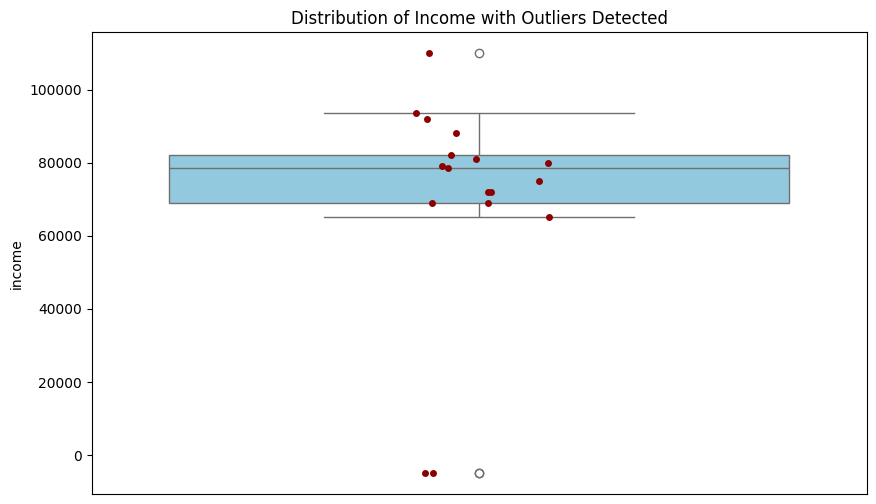

In [27]:
visualize_outliers_boxplot(df['income'])

In [ ]:
# perform winsorization (cap outliers)
def winsorize_series(data: pd.Series,
              lower_percentile: float =.01,
              upper_percentile: float =.99) -> pd.Series:
    """
    Performs winsorization on a numeric pandas Series by capping values
    at specified lower and upper percentiles.

    This function only executes the winsorization if the input Series
    is identified as containing outliers by the `_contains_outliers` helper.
    If no outliers are detected, the original Series is returned unchanged.

    Winsorization replaces values outside the specified percentile range with
    the values at those percentiles. For example, if lower_percentile is 0.01
    and upper_percentile is 0.99, any value below the 1st percentile will be
    set to the value at the 1st percentile, and any value above the 99th
    percentile will be set to the value at the 99th percentile.

    Args:
        data (pd.Series): The numeric pandas Series on which to perform winsorization.
                          Non-numeric data will raise a TypeError.
        lower_percentile (float, optional): The lower percentile (0.0 to 1.0)
                                            to use for capping. Defaults to 0.01 (1st percentile).
        upper_percentile (float, optional): The upper percentile (0.0 to 1.0)
                                            to use for capping. Defaults to 0.99 (99th percentile).

    Returns:
        pd.Series: A new pandas Series with outliers capped at the specified percentiles.
                   Returns the original Series unchanged if no outliers are detected
                   or if the input Series is not numeric or has insufficient data.

    Raises:
        TypeError: If the input `data` Series is not of a numeric data type.
        ValueError: If `lower_percentile` or `upper_percentile` are invalid
                    (e.g., outside 0-1 range, or lower > upper).
        ValueError: If the Series contains too few non-NaN values to calculate quantiles.

    Example:
        >>> import pandas as pd
        >>> # Example with outliers
        >>> s_outliers = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 100])
        >>> print("Original Series with outliers:")
        >>> print(s_outliers)
        Original Series with outliers:
        0      1
        1      2
        2      3
        3      4
        4      5
        5      6
        6      7
        7      8
        8      9
        9    100
        dtype: int64
        >>> winsorized_s = winsorize(s_outliers, lower_percentile=0.05, upper_percentile=0.95)
        >>> print("\nWinsorized Series:")
        >>> print(winsorized_s)
        Winsorized Series:
        0     1.4
        1     2.0
        2     3.0
        3     4.0
        4     5.0
        5     6.0
        6     7.0
        7     8.0
        8     8.6
        9     8.6
        dtype: float64

        >>> # Example with no outliers (should return original series)
        >>> s_no_outliers = pd.Series([10, 20, 30, 40, 50])
        >>> print("\nOriginal Series with no outliers:")
        >>> print(s_no_outliers)
        Original Series with no outliers:
        0    10
        1    20
        2    30
        3    40
        4    50
        dtype: int64
        >>> winsorized_no_outliers_s = winsorize(s_no_outliers)
        >>> print("\nWinsorized Series (no change expected):")
        >>> print(winsorized_no_outliers_s)
        Winsorized Series (no change expected):
        0    10
        1    20
        2    30
        3    40
        4    50
        dtype: int64

        >>> # Example with non-numeric data (should raise TypeError)
        >>> try:
        ...     winsorize(pd.Series(['a', 'b', 'c']))
        ... except TypeError as e:
        ...     print(f"\nCaught expected error: {e}")
        Caught expected error: Input Series must be numeric.
    """
    print("--- Series winsorization process initiated ---\n")

    # Validate input data
    if not is_numeric_dtype(data):
        raise TypeError("Input Series must be numeric.")
    
    # Validate presence of outliers
    if not _contains_outliers(data):
        print(f"The data does not contain outliers. Exiting winsorization process...")
    
    # Validate Percentile values
    if not ((0 <= lower_percentile < 1) and (0 < upper_percentile <= 1) and (lower_percentile <= upper_percentile)):
        raise ValueError("Invalid percentile values: upper_percentile must be greater than lower_percentile.")

    # Make a copy of data without null values
    data = (data.dropna()
                .copy())

    # Ensure there is enough non-NaN values for quantiles calculation
    if len(data) < 2:
        raise ValueError("Insufficient non-NaN data to calculate percentiles for winsorization.")
    
    try:
        # Define limits for capping values based on percentile and winsorize
        lower_limit = data.quantile(lower_percentile)
        upper_limit = data.quantile(upper_percentile)
        winsorized_data = data.clip(lower=lower_limit, upper=upper_limit)
        print(f"Winsorization of '{data.name if data.name else 'this column'}' successful.")
    except Exception as e:
        raise ValueError(f"Could not calculate percentile limits for winsorization. Error: {e}")
    
    print("\n--- Series winsorization process complete ---")
    return winsorized_data

In [38]:
df['income_capped'] = winsorize_series(df['income'])

--- Series winsorization process initiated ---

Winsorization of 'income successful.

--- Series winsorization process complete ---
